In [94]:
import pandas as pd
import numpy as np
import requests as requests
from pandas import to_datetime
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
import gdown
import os



# EOLIC Production Estimation

In [95]:
url_generation_2014 = "https://drive.google.com/file/d/1yGN7I7EpEnjsuNm2jZUV4PHruBPGv8Lg/view?usp=drive_link"
url_weather_2014 = "https://drive.google.com/file/d/1688OtF5aypNOSQ7rDMKdOhhLOKjFsj7P/view?usp=drive_link"
url_weather_metadata = "https://drive.google.com/file/d/1l3bYxhw4XeGlEfsu1F4ptCqDWYl2a64x/view?usp=drive_link"
url_provincias = 'https://drive.google.com/file/d/1892NArUsU5bLbfsqLY1SoePvj5HpA9Tw/view?usp=drive_link'

In [96]:
def drive_read_file(url):
    for retry in range(3):
        try:
            # Generate the Google Drive download URL
            download_url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
            
            # Download the file using gdown
            file_path = gdown.download(download_url, quiet=False)
            
            if file_path is not None:
                # Read the file directly into a pandas DataFrame
                df = pd.read_csv(file_path)
                
                # Delete the downloaded file
                os.remove(file_path)
                
                return df
            else:
                print("Download failed. Trying again...")
                time.sleep(5.0)  # Wait for another retry
        except Exception as e:
            print(f"Error {e}. Trying again...")
            time.sleep(5.0)  # Wait for another retry
    print("Unable to download. Please try again later.")
    return None

In [97]:
#First of all, we try to create a model for eolic energy with 2014 data that we can extrapolate afterwards
generation_2014 = drive_read_file(url_generation_2014)

Downloading...
From: https://drive.google.com/uc?id=1yGN7I7EpEnjsuNm2jZUV4PHruBPGv8Lg
To: /home/dsc/data/TFM_EFAT/TFM_EFAT/Exploration_notebooks/Generation_2014.csv
100%|██████████| 470k/470k [00:00<00:00, 2.72MB/s]


In [98]:
#We use info or head fucntions to take a quick view on data
generation_2014.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6314 entries, 0 to 6313
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       6314 non-null   float64
 1   percentage  6314 non-null   float64
 2   datetime    6314 non-null   object 
 3   Type        6314 non-null   object 
dtypes: float64(2), object(2)
memory usage: 197.4+ KB


In [99]:
#In order to have a 'cleaner' datetime and to order it by datetime:

generation_2014['fecha'] = generation_2014['datetime'].str[:10]
generation_2014['fecha'] = pd.to_datetime(generation_2014['fecha'])
generation_2014 = generation_2014.sort_values(by = 'fecha', ignore_index = True)
generation_2014.head()

,value,percentage,datetime,Type,fecha
0,73065.0520,0.110822,2014-01-01T00:00:00.000+01:00,Hidráulica,2014-01-01
1,4616.7525,0.007003,2014-01-01T00:00:00.000+01:00,Residuos no renovables,2014-01-01
2,146015.5030,0.221470,2014-01-01T00:00:00.000+01:00,Nuclear,2014-01-01
3,54043.0770,0.081970,2014-01-01T00:00:00.000+01:00,Cogeneración,2014-01-01
4,25240.6550,0.038284,2014-01-01T00:00:00.000+01:00,Carbón,2014-01-01


In [100]:
generation_2014['Type'].unique()

array(['Hidráulica', 'Residuos no renovables', 'Nuclear', 'Cogeneración',
       'Carbón', 'Fuel + Gas', 'Otras renovables', 'Residuos renovables',
       'Motores diésel', 'Turbina de gas', 'Solar térmica',
       'Generación total', 'Turbina de vapor', 'Solar fotovoltaica',
       'Ciclo combinado', 'Turbinación bombeo', 'Eólica', 'Hidroeólica'],
      dtype=object)

In [101]:
#At this point we are only interested in eolic, therefore:
eolic_2014 = generation_2014[(generation_2014['Type'] == 'Eólica')]
eolic_2014.groupby('Type').describe()

value                                                             \
        count           mean        min      25%         50%         75%   
Type                                                                       
Eólica  365.0  139813.783145  10360.619  80815.6  122554.358  193319.156   

                                percentage            ...                      \
               max          std      count      mean  ...       max       std   
Type                                                  ...                       
Eólica  350063.672  74102.74163      365.0  0.189508  ...  0.437958  0.094388   

       fecha                                                                 \
       count                 mean                  min                  25%   
Type                                                                          
Eólica   365  2014-07-02 00:00:00  2014-01-01 00:00:00  2014-04-02 00:00:00   

                                                                            
                        50%                  75%                  max  std  
Type                                                                        
Eólica  2014-07-02 00:00:00  2014-10-01 00:00:00  2014-12-31 00:00:00  NaN  

[1 rows x 24 columns]

## Weather Data

In [102]:
#Let's prepare now the weather data
weather_2014 = drive_read_file(url_weather_2014)
weather_2014.info()

Downloading...
From: https://drive.google.com/uc?id=1688OtF5aypNOSQ7rDMKdOhhLOKjFsj7P
To: /home/dsc/data/TFM_EFAT/TFM_EFAT/Exploration_notebooks/Weather2014.csv
100%|██████████| 11.6M/11.6M [00:02<00:00, 5.21MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92888 entries, 0 to 92887
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fecha        92888 non-null  object 
 1   indicativo   92888 non-null  object 
 2   nombre       92888 non-null  object 
 3   provincia    92888 non-null  object 
 4   altitud      92888 non-null  int64  
 5   tmed         89480 non-null  object 
 6   prec         88915 non-null  object 
 7   tmin         89484 non-null  object 
 8   horatmin     87598 non-null  object 
 9   tmax         89506 non-null  object 
 10  horatmax     87800 non-null  object 
 11  dir          83078 non-null  float64
 12  velmedia     84451 non-null  object 
 13  racha        83081 non-null  object 
 14  horaracha    83071 non-null  object 
 15  sol          49713 non-null  object 
 16  presMax      67974 non-null  object 
 17  horaPresMax  67970 non-null  object 
 18  presMin      67973 non-null  object 
 19  hora

In [103]:
#We downloaded also the metadata from the API request to a better understanding of the variables:
weather_metadata = drive_read_file(url_weather_metadata)
weather_metadata

Downloading...
From: https://drive.google.com/uc?id=1l3bYxhw4XeGlEfsu1F4ptCqDWYl2a64x
To: /home/dsc/data/TFM_EFAT/TFM_EFAT/Exploration_notebooks/Metadata.csv
100%|██████████| 1.41k/1.41k [00:00<00:00, 322kB/s]


,Unnamed: 0,id,descripcion,tipo_datos,unidad,requerido
0,0,fecha,fecha del dia (AAAA-MM-DD),string,NaN,True
1,0,indicativo,indicativo climatológico,string,NaN,True
2,0,nombre,nombre (ubicación) de la estación,string,NaN,True
3,0,provincia,provincia de la estación,string,NaN,True
4,0,altitud,altitud de la estación en m sobre el nivel del...,float,m,True
5,0,tmed,Temperatura media diaria,float,°C,False
6,0,prec,Precipitación diaria de 07 a 07,float,"mm (Ip = inferior a 0,1 mm) (Acum = Precipitac...",False
7,0,tmin,Temperatura Mínima del día,float,°C,False
8,0,horatmin,Hora y minuto de la temperatura mínima,string,UTC,False
9,0,tmax,Temperatura Máxima del día,float,°C,False


In [104]:
#There are some values in 'prec' assigned as 'Ip' when rain is almost 0.
#We are going to substitute those values - there are not many of them -  with 0

prec = weather_2014['prec'].str.contains('Ip')
precacum = weather_2014['prec'].str.contains('Acum')
prec.value_counts()


prec
False    87343
True      1572
Name: count, dtype: int64

In [105]:
#In order to replace 'Ip' values in 'prec':

weather_2014.loc[weather_2014['prec'] == 'Ip', 'prec'] = 0

In [106]:
#As we can see below there are not any more 'Ip', so we can proceed with the transformation of 'prec'
prec = weather_2014['prec'].str.contains('Ip')
precacum = weather_2014['prec'].str.contains('Acum')
prec.value_counts()

prec
False    87343
Name: count, dtype: int64

In [107]:
weather_2014_eolic = weather_2014[['fecha', 'nombre', 'provincia','prec','tmed', 'racha', 'velmedia', 'presMax', 'presMin']]
weather_2014_eolic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92888 entries, 0 to 92887
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fecha      92888 non-null  object
 1   nombre     92888 non-null  object
 2   provincia  92888 non-null  object
 3   prec       88915 non-null  object
 4   tmed       89480 non-null  object
 5   racha      83081 non-null  object
 6   velmedia   84451 non-null  object
 7   presMax    67974 non-null  object
 8   presMin    67973 non-null  object
dtypes: object(9)
memory usage: 6.4+ MB


In [108]:
#We need to eliminate now NA values
weather_2014_eolic = weather_2014_eolic.dropna()
weather_2014_eolic.info()


<class 'pandas.core.frame.DataFrame'>
Index: 61668 entries, 0 to 92887
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fecha      61668 non-null  object
 1   nombre     61668 non-null  object
 2   provincia  61668 non-null  object
 3   prec       61668 non-null  object
 4   tmed       61668 non-null  object
 5   racha      61668 non-null  object
 6   velmedia   61668 non-null  object
 7   presMax    61668 non-null  object
 8   presMin    61668 non-null  object
dtypes: object(9)
memory usage: 4.7+ MB


In [109]:
#Let's transform columns into numerica values for the model
def transform_columns(columns, x):
    for column in columns:
        x[column] = x[column].str.replace(',', '.')
        x[column] = x[column].apply(pd.to_numeric)

In [110]:
cols = ['prec','tmed', 'racha', 'velmedia', 'presMax', 'presMin']
transform_columns(cols, weather_2014_eolic)
weather_2014_eolic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61668 entries, 0 to 92887
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fecha      61668 non-null  object 
 1   nombre     61668 non-null  object 
 2   provincia  61668 non-null  object 
 3   prec       60227 non-null  float64
 4   tmed       61668 non-null  float64
 5   racha      61668 non-null  float64
 6   velmedia   61668 non-null  float64
 7   presMax    61668 non-null  float64
 8   presMin    61668 non-null  float64
dtypes: float64(6), object(3)
memory usage: 4.7+ MB


(array([4.2270e+03, 3.0468e+04, 1.8439e+04, 6.1260e+03, 1.8160e+03,
        4.3400e+02, 1.0200e+02, 3.4000e+01, 1.7000e+01, 5.0000e+00]),
 array([ 0.8 ,  5.58, 10.36, 15.14, 19.92, 24.7 , 29.48, 34.26, 39.04,
        43.82, 48.6 ]),
 <BarContainer object of 10 artists>)

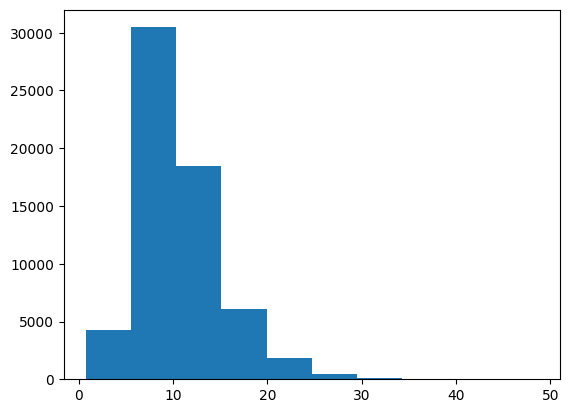

In [111]:
plt.hist(weather_2014_eolic['racha'])

In [112]:
def drive_read_latin_encoding_file(url): #In order to download the files with the urls provided at the beginning of the notebook and that are uin xslsx format:

    for retry in range(3):
        try:

            # Generate the Google Drive download URL
            download_url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
            
            # Download the file using gdown
            file_path = gdown.download(download_url, quiet=False)

            if file_path is not None:
            
                # Read the file directly into a pandas DataFrame
                df = pd.read_csv(file_path, encoding = 'latin-1', sep = ';')
                
                # Delete the downloaded file
                os.remove(file_path)
                return df
            else:
                print("Download failed. Trying again...")
                time.sleep(5.0)  # Wait for another retry

        except Exception as e:
            print(f"Error {e}. Trying again...")
            time.sleep(5.0)  # Wait for another retry

    print("Unable to download and read the file. Please try again later.")
    return None



In [113]:
cod_provincias_file = drive_read_latin_encoding_file(url_provincias)

Downloading...
From: https://drive.google.com/uc?id=1892NArUsU5bLbfsqLY1SoePvj5HpA9Tw
To: /home/dsc/data/TFM_EFAT/TFM_EFAT/Exploration_notebooks/CodProvincias.csv
100%|██████████| 1.52k/1.52k [00:00<00:00, 601kB/s]


In [114]:
def cod_provincias(cod_provincias_df):

    """
    In order to transform codprovincias dataframe so it can be crossmatched with other files, we haver several things to adapt in columns format:
    """

    cod_provincias_df.rename(columns = {'Provincia': 'provincia'},inplace= True)
    cod_provincias_df['provincia'] = cod_provincias_df['provincia'].apply(unidecode).str.upper()
    cod_provincias_df['Comunidad Autónoma'] = cod_provincias_df['Comunidad Autónoma'].apply(unidecode).str.upper()
    cod_provincias_df = cod_provincias_df.rename(columns = {'Comunidad Autónoma':'comunidad_autonoma'})
    return cod_provincias_df

In [115]:
codprovincias = cod_provincias(cod_provincias_file)

In [116]:
weather_2014_eolic_cpro = weather_2014_eolic

weather_2014_eolic_cpro = pd.merge(weather_2014_eolic_cpro, codprovincias, how = 'left', on= 'provincia')

In [117]:
weather_2014_eolic_cpro_na = weather_2014_eolic_cpro[weather_2014_eolic_cpro['CPRO'].isna()]
weather_2014_eolic_cpro_na['provincia'].unique()

array(['STA. CRUZ DE TENERIFE', 'CASTELLON', 'ALICANTE', 'A CORUÑA',
       'VALENCIA'], dtype=object)

In [118]:
    #We need some replacements in 'provincias' in order to match it with the other files and to avoid NAs values. Then it should work. Let's repeat the same code:


weather_2014_eolic['provincia'] = weather_2014_eolic['provincia'].replace('VALENCIA','VALENCIA/VALENCIA')
weather_2014_eolic['provincia'] = weather_2014_eolic['provincia'].replace('STA. CRUZ DE TENERIFE','SANTA CRUZ DE TENERIFE')
weather_2014_eolic['provincia'] = weather_2014_eolic['provincia'].replace('A CORUÑA', 'A CORUNA')
weather_2014_eolic['provincia'] = weather_2014_eolic['provincia'].replace('ALICANTE','ALICANTE/ALACANT')
weather_2014_eolic['provincia'] = weather_2014_eolic['provincia'].replace('CASTELLON', 'CASTELLON/CASTELLO')
weather_2014_eolic_cpro = pd.merge(weather_2014_eolic, codprovincias, how = 'left', on= 'provincia')



In [119]:
weather_2014_eolic_cpro_na = weather_2014_eolic_cpro[weather_2014_eolic_cpro['CPRO'].isna()]
weather_2014_eolic_cpro_na['provincia'].unique()

array([], dtype=object)

There are no NA values now!

In [120]:
weather_2014_eolic_cpro.head(10)

,fecha,nombre,provincia,prec,tmed,racha,velmedia,presMax,presMin,CPRO,CODAUTO,comunidad_autonoma
0,2014-01-01,DON BENITO,BADAJOZ,0.0,11.0,8.3,2.2,989.9,984.9,6,11,EXTREMADURA
1,2014-01-01,TENERIFE NORTE AEROPUERTO,SANTA CRUZ DE TENERIFE,0.0,12.1,6.7,3.6,953.8,951.3,38,5,CANARIAS
2,2014-01-01,ANTEQUERA,MALAGA,0.0,11.4,6.4,1.4,975.0,971.4,29,1,ANDALUCIA
3,2014-01-01,TALARN,LLEIDA,4.6,2.6,5.0,1.1,924.8,919.7,25,9,CATALUNA
4,2014-01-01,OURENSE,OURENSE,16.5,12.0,11.7,2.2,999.3,989.1,32,12,GALICIA
5,2014-01-01,VILLAFRANCA DEL CID/VILLAFRANCA,CASTELLON/CASTELLO,0.0,7.9,10.6,1.4,890.0,884.9,12,10,COMUNITAT VALENCIANA
6,2014-01-01,ALACANT/ALICANTE,ALICANTE/ALACANT,0.0,15.7,8.1,1.9,1011.3,1007.5,3,10,COMUNITAT VALENCIANA
7,2014-01-01,STA.CRUZ DE TENERIFE,SANTA CRUZ DE TENERIFE,0.0,16.0,7.5,2.2,1020.8,1018.2,38,5,CANARIAS
8,2014-01-01,BIELSA,HUESCA,15.8,2.6,7.5,1.7,904.2,899.8,22,2,ARAGON
9,2014-01-01,BURGOS AEROPUERTO,BURGOS,5.8,6.8,16.9,9.7,914.6,907.3,9,7,CASTILLA Y LEON


In [121]:
#We calculate now the mean for the main variables that we are going to use in our calculations for each day
eolic_pivot_table = weather_2014_eolic.groupby(['fecha', 'provincia'], as_index=False)[['prec','tmed', 'racha', 'velmedia', 'presMax', 'presMin']].mean()
eolic_pivot_table = eolic_pivot_table.groupby('fecha', as_index = False)[['prec','tmed', 'racha', 'velmedia', 'presMax', 'presMin']].mean()
eolic_pivot_table

,fecha,prec,tmed,racha,velmedia,presMax,presMin
0,2014-01-01,4.087549,9.342361,12.118814,3.690673,960.665983,954.491581
1,2014-01-02,5.087137,11.380689,11.598547,3.299038,958.082500,954.761303
2,2014-01-03,5.212885,12.150833,11.026079,2.977468,961.032372,956.787863
3,2014-01-04,6.207436,9.323077,20.822585,5.754380,961.253526,950.443504
4,2014-01-05,1.700919,8.656923,13.040929,3.571432,964.355107,960.007703
...,...,...,...,...,...,...,...
360,2014-12-27,4.441415,7.856613,12.423451,3.424882,971.102073,960.302057
361,2014-12-28,1.414027,7.143910,14.710294,4.707837,967.712025,958.866864
362,2014-12-29,0.111026,4.338638,12.444407,3.581266,977.103462,967.076490
363,2014-12-30,0.019872,4.360135,8.635110,2.478924,977.061630,973.548061


In [122]:
#In order to be able to mix it with generation data, we need to adapt 'fecha' field
eolic_pivot_table['fecha']=eolic_pivot_table['fecha'].apply(to_datetime)

In [123]:
#Now it is time to mix the generation and weather data

eolic_model = pd.merge(eolic_2014 , eolic_pivot_table, how = 'inner', on = 'fecha')
eolic_model

,value,percentage,datetime,Type,fecha,prec,tmed,racha,velmedia,presMax,presMin
0,257896.205,0.391166,2014-01-01T00:00:00.000+01:00,Eólica,2014-01-01,4.087549,9.342361,12.118814,3.690673,960.665983,954.491581
1,270764.404,0.366209,2014-01-02T00:00:00.000+01:00,Eólica,2014-01-02,5.087137,11.380689,11.598547,3.299038,958.082500,954.761303
2,248822.078,0.332673,2014-01-03T00:00:00.000+01:00,Eólica,2014-01-03,5.212885,12.150833,11.026079,2.977468,961.032372,956.787863
3,315077.619,0.420168,2014-01-04T00:00:00.000+01:00,Eólica,2014-01-04,6.207436,9.323077,20.822585,5.754380,961.253526,950.443504
4,260674.588,0.375069,2014-01-05T00:00:00.000+01:00,Eólica,2014-01-05,1.700919,8.656923,13.040929,3.571432,964.355107,960.007703
...,...,...,...,...,...,...,...,...,...,...,...
360,230548.649,0.330679,2014-12-27T00:00:00.000+01:00,Eólica,2014-12-27,4.441415,7.856613,12.423451,3.424882,971.102073,960.302057
361,298721.125,0.412681,2014-12-28T00:00:00.000+01:00,Eólica,2014-12-28,1.414027,7.143910,14.710294,4.707837,967.712025,958.866864
362,233870.648,0.306219,2014-12-29T00:00:00.000+01:00,Eólica,2014-12-29,0.111026,4.338638,12.444407,3.581266,977.103462,967.076490
363,155414.492,0.207185,2014-12-30T00:00:00.000+01:00,Eólica,2014-12-30,0.019872,4.360135,8.635110,2.478924,977.061630,973.548061


# Data Visualization

In [124]:
eolic_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   value       365 non-null    float64       
 1   percentage  365 non-null    float64       
 2   datetime    365 non-null    object        
 3   Type        365 non-null    object        
 4   fecha       365 non-null    datetime64[ns]
 5   prec        365 non-null    float64       
 6   tmed        365 non-null    float64       
 7   racha       365 non-null    float64       
 8   velmedia    365 non-null    float64       
 9   presMax     365 non-null    float64       
 10  presMin     365 non-null    float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 31.5+ KB


In [138]:
eolic_model['dif_pres'] = eolic_model['presMax']- eolic_model['presMin']

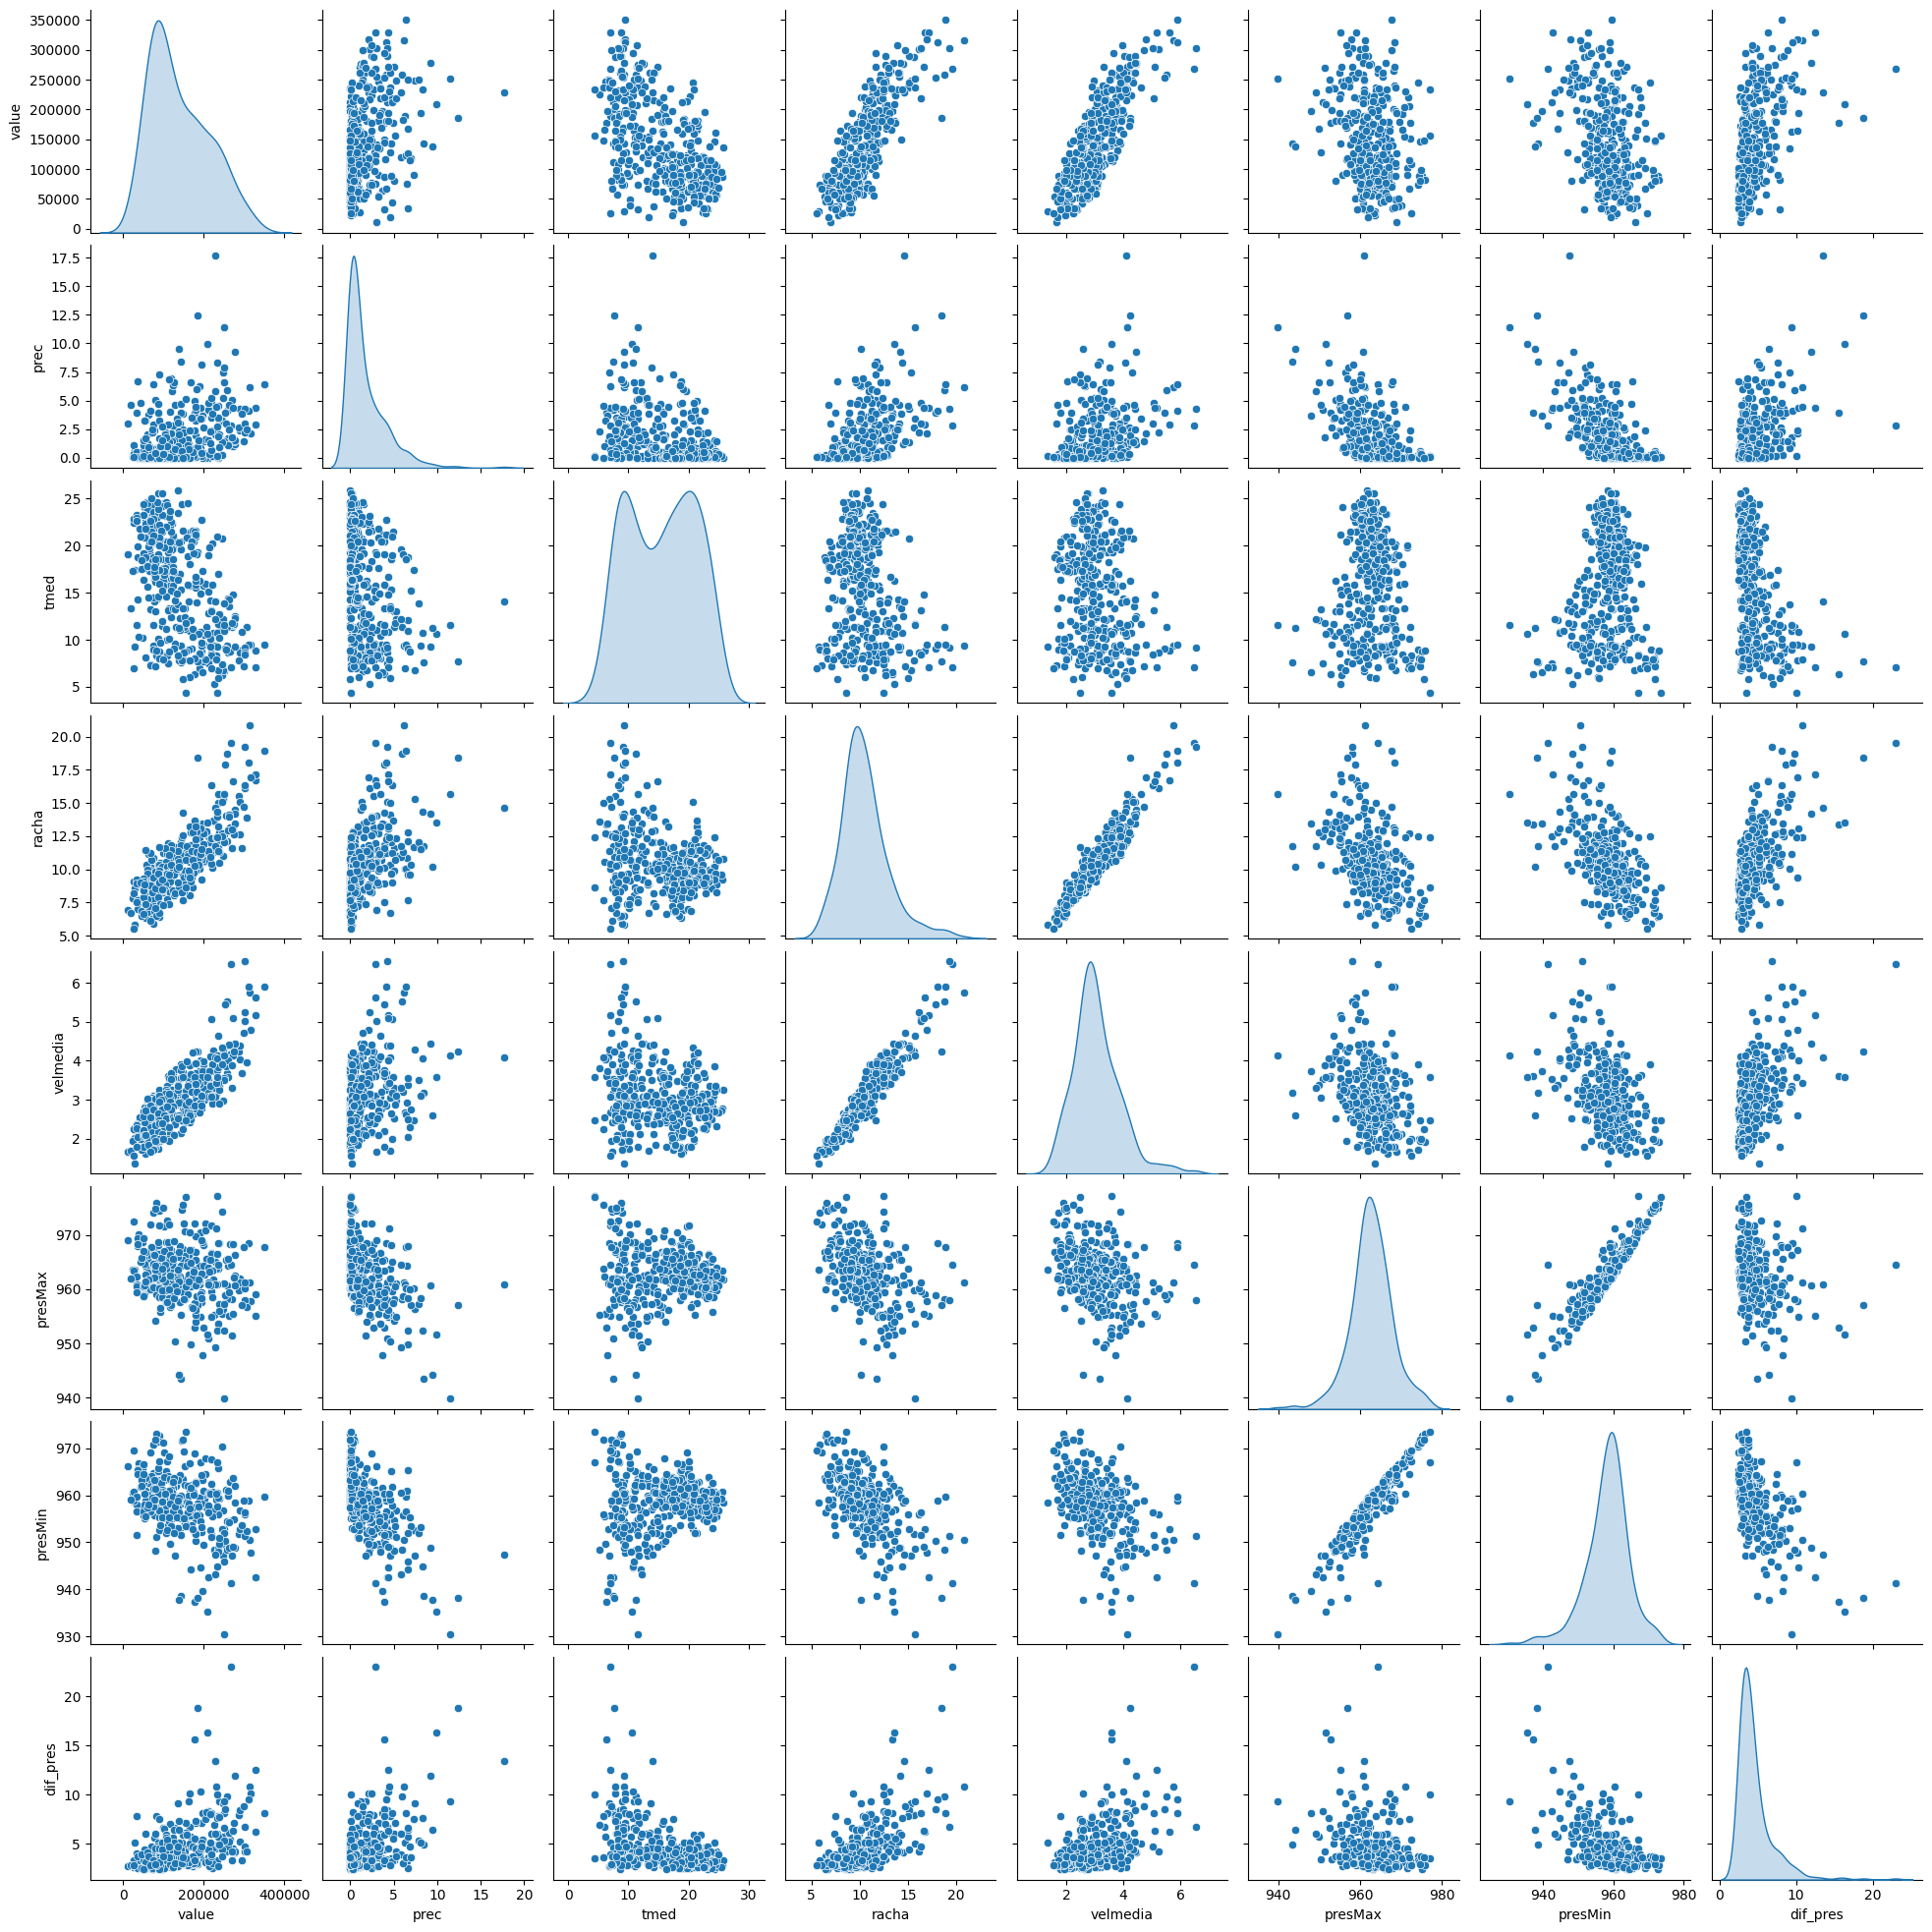

In [139]:
sns.pairplot(eolic_model[['value','prec', 'tmed', 'racha', 'velmedia', 'presMax', 'presMin', 'dif_pres']],diag_kind='kde')

<Axes: xlabel='value', ylabel='Count'>

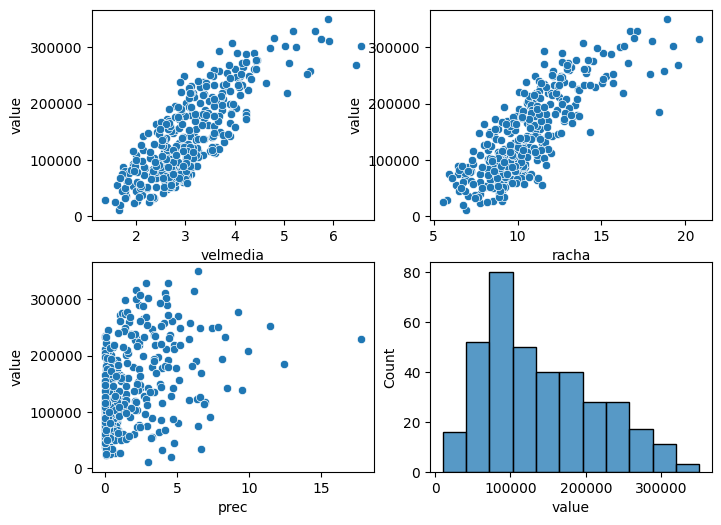

In [126]:
fig, axes = plt.subplots(2,2, figsize = (8,6))
sns.scatterplot(ax = axes[0,0], data = eolic_model , x = 'velmedia', y = 'value')
sns.scatterplot(ax = axes[0,1], data = eolic_model , x = 'racha', y = 'value')
sns.scatterplot(ax = axes[1,0], data = eolic_model , x = 'prec', y = 'value')
sns.histplot(ax = axes[1,1], data = eolic_model['value'])

# EOLIC ML Model

In [127]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [128]:
#We are going to create the model based on linear regression first
#Transform dataframe objects to numpy is needed to be able to reshape the data afterwards

X_eolic = eolic_model[['velmedia', 'racha', 'prec']].to_numpy()

scaler = StandardScaler()

X_eolic_scaled = scaler.fit_transform(X_eolic)

y_eolic = eolic_model['value'].to_numpy()

In [129]:
def lr_model (X,y):

    #Estimator would be LR from sklearn

    reg = LinearRegression()

    # Get the number of the features we are including to reshape accordingly afterwards
    shape = X.shape[1]

    #Reshape in order to have data adjusted

    X = X.reshape(-1,shape)
    y = y.reshape(-1,1)

    print(X.shape)
    print(y.shape)

    #Fit in order to train the data
    reg.fit(X,y)

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

    #Metrics of the model we want to know

    predictions = reg.predict(X)
    MAE = np.round(mean_absolute_error(y_test, reg.predict(X_test)),2)
    r2 = np.round(r2_score(y_test, reg.predict(X_test)),3)
    MSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = True),2)
    RMSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = False),2)
    cv = cross_val_score(reg, X, y, cv = 5)
    cv_mean = np.round(cv.mean(), 3)
    cv_std = np.round(cv.std(), 3)


    #Outputs
    
    print(f'Model intercept is {reg.intercept_}')
    print(f'Model coefficient is {reg.coef_}')
    print(f'Model MAE is {MAE}')
    print(f'Model MSE is {MSE}')
    print(f'Model r2 is {r2}')
    print(f'Model RMSE is {RMSE}')
    print(f'CV mean is {cv_mean} and std is {cv_std}')

    return predictions

In [130]:
#Let's check how the model works

lr_model(X_eolic, y_eolic)

(365, 3)
(365, 1)
Model intercept is [-90834.67650697]
Model coefficient is [[48530.93341884  7313.70221073  2661.76306444]]
Model MAE is 29848.79
Model MSE is 1274913248.86
Model r2 is 0.693
Model RMSE is 35705.93
CV mean is 0.322 and std is 0.342


array([[187790.61735769],
       [167639.81102438],
       [148181.54479294],
       [357243.6857138 ],
       [182395.15151086],
       [136191.8621799 ],
       [ 87267.71957984],
       [102690.52829397],
       [ 45611.39205419],
       [ 46276.40399225],
       [ 18008.30598044],
       [ 82446.19109412],
       [149223.2641228 ],
       [204255.81532176],
       [132350.50551308],
       [155383.89790958],
       [183222.16469489],
       [171691.10771733],
       [192369.39197311],
       [204998.14692702],
       [129094.64583041],
       [149415.10726993],
       [149858.61927009],
       [214948.46142482],
       [208061.94377622],
       [169720.46651715],
       [311697.37905597],
       [297389.69174218],
       [198391.00927143],
       [205854.55615235],
       [148692.66873416],
       [235113.83175321],
       [112756.04473343],
       [199614.53807449],
       [249454.5430624 ],
       [271789.19782538],
       [329863.20991141],
       [244717.64754036],
       [3151

In [131]:
#Let's check now if the model improves if we standarize data

X_eolic_log = np.log(X_eolic)
y_eolic_log = np.log(y_eolic)

X_eolic_log[np.isneginf(X_eolic_log)] = 0
X_eolic_log

/tmp/ipykernel_2741/1368819934.py:3: RuntimeWarning: divide by zero encountered in log
  X_eolic_log = np.log(X_eolic)


array([[ 1.30580885,  2.49475913,  1.40794553],
       [ 1.19363105,  2.45087983,  1.62671515],
       [ 1.09107326,  2.40026329,  1.65113337],
       ...,
       [ 1.27571638,  2.52127129, -2.1979941 ],
       [ 0.90782459,  2.15583644, -3.9184539 ],
       [ 0.80324201,  2.04096341, -7.3524411 ]])

In [132]:
lr_model(X_eolic_log, y_eolic_log)

(365, 3)
(365, 1)
Model intercept is [9.14519163]
Model coefficient is [[1.33110775 0.47458568 0.00961073]]
Model MAE is 0.26
Model MSE is 0.11
Model r2 is 0.595
Model RMSE is 0.33
CV mean is 0.305 and std is 0.265


array([[12.08087225],
       [11.91282956],
       [11.75252688],
       [12.9329858 ],
       [12.06353224],
       [11.73338357],
       [11.30305093],
       [11.45787831],
       [10.79255452],
       [10.82604228],
       [10.37144087],
       [11.18665814],
       [11.7983721 ],
       [12.21738705],
       [11.64684314],
       [11.85823473],
       [12.03794676],
       [11.87281392],
       [12.09549786],
       [12.23510508],
       [11.56546775],
       [11.80580937],
       [11.8572381 ],
       [12.27862187],
       [12.25445915],
       [11.96782155],
       [12.7893039 ],
       [12.69666815],
       [12.1437216 ],
       [12.21550603],
       [11.79474914],
       [12.37518542],
       [11.50911127],
       [12.17230956],
       [12.39996644],
       [12.58359383],
       [12.82775631],
       [12.4203159 ],
       [12.78523457],
       [12.47078904],
       [13.05126352],
       [12.32208711],
       [11.82665505],
       [12.39956987],
       [12.64532727],
       [11

In [133]:
#Let's try removing 'prec' from the model as it seems to be a variable not higly related
X_eolic = eolic_model[['velmedia', 'racha']].to_numpy()
y_eolic = eolic_model['value'].to_numpy()

In [134]:
lr_model(X_eolic, y_eolic)

(365, 2)
(365, 1)
Model intercept is [-102756.88603988]
Model coefficient is [[38060.74967129 11945.66180086]]
Model MAE is 35192.37
Model MSE is 1607283403.36
Model r2 is 0.733
Model RMSE is 40090.94
CV mean is 0.312 and std is 0.346


array([[182480.15275621],
       [161359.3109462 ],
       [142281.58764885],
       [364998.70751101],
       [188957.01218945],
       [137760.91942531],
       [ 84652.75451776],
       [101040.89899599],
       [ 47395.11650011],
       [ 44678.33872233],
       [ 18269.22299052],
       [ 81516.60569156],
       [147191.08540923],
       [202160.30248139],
       [131267.65819591],
       [158897.5756422 ],
       [180738.2879395 ],
       [158659.66471152],
       [194215.70915218],
       [204612.31279766],
       [119140.91584729],
       [147277.05154514],
       [152827.55434835],
       [213402.90987054],
       [210374.57720689],
       [177011.36398593],
       [310667.2619616 ],
       [298967.08061907],
       [199627.54696787],
       [201906.49178431],
       [146897.55928978],
       [243884.33900112],
       [120261.11925724],
       [204860.14044329],
       [243488.18798336],
       [282446.49862896],
       [331064.12591257],
       [245257.5310073 ],
       [3183

In [135]:
#It seems that the model performs better. What if we make the log again?

X_eolic_log = np.log(X_eolic)
y_eolic_log = np.log(y_eolic)

lr_model(X_eolic_log, y_eolic_log)

(365, 2)
(365, 1)
Model intercept is [8.89520736]
Model coefficient is [[1.24680632 0.61862915]]
Model MAE is 0.29
Model MSE is 0.13
Model r2 is 0.519
Model RMSE is 0.35
CV mean is 0.306 and std is 0.264


array([[12.06662882],
       [11.89961982],
       [11.74043725],
       [12.95525202],
       [12.07104718],
       [11.72630341],
       [11.27899045],
       [11.43873615],
       [10.78936696],
       [10.8114804 ],
       [10.36713245],
       [11.17426314],
       [11.78819007],
       [12.2066407 ],
       [11.63975499],
       [11.85887126],
       [12.03097856],
       [11.86023203],
       [12.09790603],
       [12.2275569 ],
       [11.54781427],
       [11.79447861],
       [11.85908599],
       [12.27044907],
       [12.25409462],
       [11.97698167],
       [12.78924404],
       [12.7030718 ],
       [12.14406751],
       [12.20271772],
       [11.78496191],
       [12.38958929],
       [11.51931902],
       [12.17788122],
       [12.40054756],
       [12.60178232],
       [12.83853193],
       [12.4225367 ],
       [12.79434978],
       [12.49478056],
       [13.06198582],
       [12.32897247],
       [11.82512945],
       [12.40699843],
       [12.64565167],
       [11

### KNN Regressor

In [136]:
def knn_model (X,y):

    #Estimator would be KNN from sklearn

    reg = KNeighborsRegressor()

    # Get the number of the features we are including to reshape accordingly afterwards
    shape = X.shape[1]

    #Reshape in order to have data adjusted

    X = X.reshape(-1,shape)

    print(X.shape)
    print(y.shape)
    
    #Fit in order to train the data
    reg.fit(X,y)

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

    #Metrics of the model we want to know

    predictions = reg.predict(X).round(2)
    MAE = np.round(mean_absolute_error(y_test, reg.predict(X_test)),2)
    r2 = np.round(r2_score(y_test, reg.predict(X_test)),3)
    MSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = True),2)
    RMSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = False),2)
    cv = cross_val_score(reg, X, y, cv = 5)
    cv_mean = np.round(cv.mean(), 3)
    cv_std = np.round(cv.std(), 3)


    #Outputs
    
 
    print(f'Model MAE is {MAE}')
    print(f'Model MSE is {MSE}')
    print(f'Model r2 is {r2}')
    print(f'Model RMSE is {RMSE}')
    print(f'CV mean is {cv_mean} and std is {cv_std}')

    return predictions



In [137]:
knn_model(X_eolic_scaled, y_eolic)

(365, 3)
(365,)
Model MAE is 23489.43
Model MSE is 853007882.54
Model r2 is 0.894
Model RMSE is 29206.3
CV mean is 0.297 and std is 0.375


array([210121.4 , 214489.71, 173087.9 , 307776.11, 224114.06, 144392.98,
       121810.67,  90548.11,  63705.71,  67937.31,  50129.62, 104320.31,
       190574.3 , 253824.23, 147485.63, 182065.79, 204692.44, 200885.57,
       183150.82, 240803.03, 126352.94, 180751.37, 159104.57, 238823.92,
       248163.63, 214028.23, 299479.36, 274904.02, 202909.7 , 247049.49,
       190574.3 , 263912.14,  93266.06, 258161.04, 251411.75, 288836.55,
       297867.58, 262205.07, 299041.89, 231269.84, 293076.82, 225792.04,
       186921.15, 255559.97, 271454.46, 167120.02, 121810.67, 107120.03,
        85710.52, 100269.34, 185225.44, 209088.8 , 135758.44, 181809.33,
       161620.95, 234027.69, 194097.44, 145320.33, 291207.57, 243916.4 ,
       286512.08, 309645.36, 309668.73, 208321.69,  90442.49,  89152.98,
        91766.39, 163844.08, 130724.19, 143032.31, 114602.37,  55830.56,
        79395.29, 102224.08, 102500.66,  77760.72,  87030.62, 104377.68,
        75952.42, 114782.4 , 247584.34, 205882.34, 